* 본 커널은 다음 커널을 참조하여, 공부를 위한 목적으로 따라 쓴 커널임.
* It is referenced by the kernel down below for study.

https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

## 사용할 모듈 불러오기.

In [ ]:
# numpy and pandas for data manipulation
import pandas as pd
import numpy as np

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system management
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 읽어들이기

먼저, 사용가능한 모든 파일을 리스트 업 해본다. 9개의 파일이 있으며,각각 1개씩 훈련, 테스트 파일이 있다. 또한, 제출 예시 파일과 6개의 피쳐 내용이 들어있는 파일이 있음.

In [ ]:
# List of files available.
print(os.listdir('../input/home-credit-default-risk/'))

In [ ]:
# Training data
app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
print('Training data shape : ', app_train.shape)
app_train.head()

훈련데이터에는 307511개의 각각 론을 한 사람에대해 데이터를 가지고 있으며, 122개의 피쳐 컬럼을 보여준다. 피쳐가 완전 많네.

In [ ]:
# Testing data features
app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
print('Testing data shape : ', app_test.shape)
app_test.head()

테스트 파일은 훈련 파일에 비해 상당히 데이터 수는 작다. 
`Target`컬럼이 빠져있는 것이 특징. 컬럼수가 121인 것에 주목!

## EDA(Exploratory Data Analysis)

EDA를 통해서 데이터들의 통계적인 추이, 데이터 간의 관계 및 어떤 패턴들을 파악할 수 있다.
목표는, 데이터들이 어떤 것들을 얘기하고 있는지 파악하는 것이며, 전체적인 추이를 먼저 확인하고, 점점 좁혀 나가는 순으로 하는것이 좋다.
데이터들의 어떤 패턴을 파악하면, 모델을 선택하는데 도움을 줄 수 있고, 어떤 피쳐들을 사용할 지 결정할 수 있도록 해준다.

### Examine the Distribution of the Target Column

타켓은 론에 대해서 대상자가 론을 모두 상환 할 것인지 아닌지를 바이너리 분류로 0 또는 1로 나타내고 있다.

0이 모두 정해진 기간내에 정상 상환하는 경우

1의 경우는 상환하지 못하는 경우를 나탐냄!



In [ ]:
app_train['TARGET'].value_counts()

그래도 정상 상환 하는 경우(0이 나오는 숫자)가 훨씬 많네.

히스토그램으로 두 데이터를 시각화 해보자!

In [ ]:
app_train['TARGET'].astype(int).plot.hist()

> From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

### Examine Missing value

이제 각 컬럼의 missing value의 수와 그 퍼센티지를 확인해보자.

In [ ]:
# Total missing values
mis_val = app_train.isnull().sum()

# Percentage of missing values
mis_val_percent = 100 * mis_val / len(app_train)

In [ ]:
len(app_train)

In [ ]:
mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

In [ ]:
mis_val_table

In [ ]:
# Rename the columns
mis_val_table_ren_columns = mis_val_table.rename(
    columns = {
        0:'Missing Values',
        1:'% of Total Values'
    }
)

In [ ]:
mis_val_table_ren_columns

In [ ]:
# Sort the table by percentage of missing descending
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
'% of Total Values', ascending=False).round(1)

# Print some summary information
print('Your selected dataframe has ' + str(app_train.shape[1]) + ' columns.\n''There are '+str(mis_val_table_ren_columns.shape[0]) + ' columns that have missing values'
     )

In [ ]:
mis_val_table_ren_columns

위의 과정을 함수화 하여 다시 표현한다!

In [ ]:
def missing_values_table(df):
    """
    param : 
        df : pandas DataFrame data, processing target dataframe.
    Return :
        mis_val_table_ren_columns : pandas DataFrame , 
        column data extracted from df that has null data
    """
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)
    
    # Make a table with the results / concat은 지정 데이터를 합쳐준다.
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0:'Missing Values',
        1:'% of Total Values'
    })
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns=mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1]!=0].sort_values(
        '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print('You selected dataframe has '+str(df.shape[1])+' columns.\n'
    'There are '+str(mis_val_table_ren_columns.shape[0])+' columns that have missing values.')
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

> When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

머신러닝 모델을 만드는데 있어서, 이런 눌 데이터를 채워야 한다.(imputation?)
나중에 우리는 XGBoost 같은 것을 사용해서 눌 데이터에 대한 imputation 할 필요가 없다?
또 다른 하나의 옵션으로는 눌 데이터가 많은 컬럼을 아예 삭제(드랍) 해버리는 방법인데, 이런 컬럼이 중요하지 않다는 것을 확인하기 어렵기 때문에, 일단 여기서는 다 남겨 놓고 진행한다.

### Column Types

각 데이터 타입에 따른 컬럼의 숫자를 확인한다. `int64`, `float64`는 수치적인 값을 나타낸다(연속적 또는 불연속적일 수 있음). 객체(object) 컬럼은 문자열 그리고 카테고리컬 피쳐 내용을 가지고 있음.

In [ ]:
# Number of each type of column
app_train.dtypes.value_counts()

이제, 객체 내용을 가지는 특별한 컬럼의 데이터를 살표본다.

In [ ]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)
# pd.Series.nunique 메소드는 각 카테고리 컬럼의 데이터를 분류하는 분류자 수를 반환함 // 아래 참조

In [ ]:
# 실제 이렇게 데이터 타입을 선택해서 출력해보면, 각 컬럼별로 어떤 종류의 분류자로 분류 되는지 볼 수 있고, 
# nunique는 기본적으로 null데이터는 제외하고 분류자 갯수를 반환해준다.
app_train.select_dtypes('object')

기관 분류인 `ORGANIZATION_TYPE` 이 가장 많은 분류자를 가지고 있다.

### Encoding Categorical Variables

카테고리 변수들은 문자열 등으로 이루어 져 있기 때문에, 모델에 바로 적용 할 수 없다.

그래서, 이런 변수들을 수치적으로 encoding 해줘야 하는데 다음 두가지 방법을 활용 할 수 있다.


1. Label encoding :

각 분류자 별로 정수값을 할당해서 분류한다. 즉, 새로운 컬럼을 만들 필요없이 해당 분류에 맞는 정수값을 할당해서 바꿔주면 됨
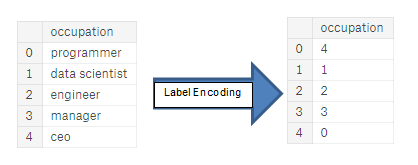

2. One-hot encoding : 

한 id 별로 분류장의 컬럼을 모두 생성해서, 해당되는 컬럼에 1을 할당하고,
나머지 컬럼에는 0을 할당하는 방식, 이렇게 하면 컬럼은 많아 지기 때문에 엄청 데이터양이 커지는 것 같음.
근데 구분하기에는 좋은거 같음
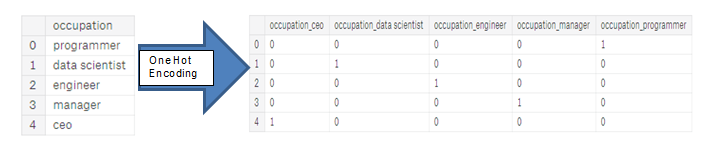

* 참고사항 : 라벨 인코딩 vs. 원-핫 인코딩에 대한 설명 


>The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

>There is some debate about the relative merits of these approaches, and some models can deal with label encoded categorical variables with no issues. Here is a good Stack Overflow discussion. I think (and this is just a personal opinion) for categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by PCA or other dimensionality reduction methods to reduce the number of dimensions (while still trying to preserve information).

>In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. This process may need to change as we get further into the project, but for now, we will see where this gets us. (We will also not use any dimensionality reduction in this notebook but will explore in future iterations).


즉, 카테고리 분류에서 분류자가 2개 이상이면, 원-핫 인코딩을 쓰고, 2개일경우는 라벨인코딩으로 진행한다.

2개일경우에만 라벨인코딩을 쓰는 이유는, 2개 이상일 때 라벨 인코딩을 쓰면 임의적인 순서를 부여하는 것이기 때문에 어떤 분류자에 대한 특정 가중치가 가해지는 효과? 가 생기는 것으로 생각되므로, 2개 이상의 분류자를 가질 때는 원-핫 인코딩을 쓰는게 좋다.

하지만 안좋은 점은 분류자 수만큼 컬럼이 증가하기 때문에 엄청난 양의 데이터가 생성된다는 점만 빼면 원-핫 인코딩이 훨씬 좋다고 함.

### Label Encoding and One-Hot Encoding

그래서, 카테고리 데이터의 dtype==object 이면서 분류자가 2개이면 label encoding을 사용!

분류자가 2개이상의 경우에는 one-hot encoding을 채용해서 사용함.

라벨 인코딩에서는 Scikit-Learn `LabelEncoder`을 사용하고,
one-hot encoding 에서는 pandas 의  `get_dummies(df)` 함수를 사용한다.

In [ ]:
# Create a label encoder object.
le = LabelEncoder()
le_count = 0

In [ ]:
# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            
            # Train on the training data
            le.fit(app_train[col])
            # Transform both Training and Testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            print('%s is processed !' % col)
            # Keep track of how many columns label encoded
            le_count +=1            
            
print('%d columns were label encoded' % le_count)

In [ ]:
app_train[['FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE']].head(10)

라벨 인코딩 된걸 확인할 수 있다

In [ ]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Feature shape', app_train.shape)
print('Testing Feature shape', app_test.shape)

### Aligning Training and Testing Data

일단, 트레이닝/테스팅 컬럼 수 차이가 타겟 컬럼 하나만 나는게 정상인데, 현재 데이터를 보면 차이가 있다. 

> There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!

테스트 데이터에는 없는 컬럼데이터(카테고리 데이터)가 트레이닝 데이터에 있기 때문에 차이가 나는데, 그 컬럼들을 제거 해주는 게 좋다.

즉, 트레이닝에만 있는 컬럼들을 삭제해서, 테스트 데이터와 align 해줘야 한다는 말!

먼저, 트레이닝 데이터를 가공해야되는데, 타겟데이터를 살려두기 위해서 따로 저장해놓자!

주의할 점은 axis=1의 컬럼데이터를 가공해야하는 점!, axis=0의 경우에는 row 데이터를 나타냄!

In [ ]:
train_labels=app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join='inner', axis=1)

# Add the target back in
app_train['TARGET'] = train_labels

In [ ]:
print('Training Feature shape', app_train.shape)
print('Testing Feature shape', app_test.shape)

app_test 컬럼에 맞춰서 app_train 데이터의 컬럼수를 맞췄다!

> The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try dimensionality reduction (removing features that are not relevant) to reduce the size of the datasets.

원래 app_train 데이터의 컬럼수가 122개 였는데, 엄청 늘었네. one-hot encoding으로 240개 까지 늘었다.

영향이 적은 내용들에 대해서는 차원을 줄이기 위해서 골라낼 필요가 있다.

### Back to Exploratory Data Analysis

Anomalies(변칙적인, 이례적인 내용들)

> One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:


데이터 값들 중에 이례적으로, 문제가 있는 값들을 찾아내야 한다. 타입이 잘못되거나, 측정이 잘못될수도 있고 여러가지 잘못된 경우가 있을 수 있다.

그래서, 각 컬럼에 대해서 정량적으로 확인 해보는 것 이 좋은데, `describe` 메소드를 이용해서 정량적으로 데이터의 통계 데이터를 확인할 수 있다.

`DAYS_BIRTH` 컬럼은 현재 론 대상자의 나이를 상대적으로 나타내기 때문에 음수로 표시되어 있다. 그러므로 -1을 곱해서 양수화 시키고 나이 값으로 변환해보자.



In [ ]:
# original DAYS_BIRTH 데이터 값
app_train[['DAYS_BIRTH']].head(10)

In [ ]:
(app_train['DAYS_BIRTH'] / (-365)).describe()

평균치랑 중간값(50%분위수)이 거의 근사한 수치를 가지며, 최대/최소값도 아웃라이어라고 판단되지는 않으며 크게 문제는 없는 것으로 판단된다!

다음으로는, `DAYS_EMPLOYED` 수치를 확인해보자!

In [ ]:
(app_train['DAYS_EMPLOYED']).describe()

최소값이 일단, 음수이고, 최대값은 1000이며, 75% 분위수가 여전이 음수이다. 이상한 거 같다. 

그리고, 연(year) 수로 환산했는데, 1000년이 나왔으므로, 올바른 데이터는 아닌듯.

In [ ]:
(app_train['DAYS_EMPLOYED']).plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment')

전체 데이터 중에서 이례적인 데이터? 1000년이 넘는 고용기간으로 나오는 데이터?가 일반 데이터들의 통계 수치보다 높은지 낮은지 부분으로 떼어내서 살펴보자.
즉, 정상인 데이터, 정상이 아닌 데이터!

In [ ]:
# DAYS_EMPLOYED 값이 최대값을 갖는 고객 데이터를 모두 가져와서 anom에 저장
anom = app_train[app_train['DAYS_EMPLOYED']==365243]
# DAYS_EMPLOYED 값이 최대값이 아닌 고객 데이터를 모두 가져옴!
non_anom = app_train[app_train['DAYS_EMPLOYED']!=365243]

In [ ]:
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anamalous days of employment' % len(anom))

> Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.
Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.


디폴트 값, 즉 타겟값의 평균값이 이례적인 경우의 데이터가 더 작다. 즉 지정 시기에 돈을 모두 갚을 확률이 높다는 건데 음...여기서는 가장 안전화 데이터 가공 방법으로는, 이런 이례적인 데이터 들에 대해서

missing value 취급을 한다고 한다. 하지만 `np.nan`값으로 모두 채워준다고 한다. 그리고, boolean컬럼을 새로 만들어서 해당 고객 정보가 이례적인 데이터인지 아닌지를 알려주는 용도로 사용한다.

In [ ]:
# Create anomalous flag column
# 해당 데이터가 있는 곳엔 True를 반환해줌
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED']==365243

# Replace the anomalous values with nan
# numpy의 nan을 사용, 사전형 형태로 데이터가 365243인 곳에 np.nan을 반환해줌!
app_train['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)

# 그럼 다시, 히스토그램을 그려서, 데이터의 가공 상태를 확인
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram after processing ANOM data');
plt.xlabel('Days Employment');



In [ ]:
(app_train[['DAYS_EMPLOYED']] / (-365)).describe()

데이터를 가공하니 분포가 매끄럽게 자연스러워 졌다.

테스트 데이터에도 똑같은 작업을 해줘야한다. 즉, 최대값을 먼저 같은지 확인해보고, 이례적인 데이터는 분류해서 nan값으로 채워준다.

In [ ]:
app_test['DAYS_EMPLOYED'].describe()

역시 트레이닝 데이터와 같게 이상치가 보인다.

In [ ]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] == 365243
app_test['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)

In [ ]:
print('There are %d anomalies in the test data out of %d entries' % 
      (app_test['DAYS_EMPLOYED_ANOM'].sum(), len(app_test)))

`DAYS_EMPLOYED_ANOM`의 TRUE값을 다 더하게 되면 9274개가 나옴을 확인할 수 있다.

In [ ]:
app_test[app_test['DAYS_EMPLOYED']==365243]

`DAYS_EMPLOYED == 365243` 이 참인 곳은 위와 같이 데이터가 없음을 확인가능!

### Correlations

>Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.
The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

* .00-.19 “very weak”
* .20-.39 “weak”
* .40-.59 “moderate”
* .60-.79 “strong”
* .80-1.0 “very strong”

데이터 간의 상관관계를 피어슨계수를 통해서 확인 할 수 있으며, `corr` 메소드를 이용함.

1에 가까운 수치는 Positive 상관관계 / -1에 가까운 수치는 Negative 상관관계를 가짐.

0이 되면 상관관계가 없다고 판단하면 됨

In [ ]:
# 먼저 전체적인 코릴레이션 계수를 이렇게 출력할 수 있다. 디폴트는 피어슨 방법으로 코릴레이션 함
corrmat = app_train.corr()
corrmat

위 수치들을 heatmap을 통해서 시각화 된 데이터를 확인한다.

In [ ]:
f, ax = plt.subplots(figsize=(20,15))
sns.heatmap(corrmat, vmax=1.0, square=True)

컬럼 수가 너무 많아서 이건 못본다. 패스!

In [ ]:
# Find correlations with the target and sort
corrmat = corrmat['TARGET'].sort_values()


In [ ]:
# Display correlations
print('Most Positive Correlations : \n', corrmat.tail(15))
print('\n')
print('Most Negative Correlations : \n', corrmat.head(15))

> Let's take a look at some of more significant correlations: the DAYS_BIRTH is the most positive correlation. (except for TARGET because the correlation of a variable with itself is always 1!) Looking at the documentation, DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

내가 이해하기론, 다음과 같다. 일단, 문서상 DAYS_BIRTH 는 대출 당시 고객의 연령을 의미한다.

Positive 수치가 높다는 의미는 즉, 해당 feature 값이 증가함에 따라 타겟 값도 증가한다. 즉, feature값의 증가함에 따라 대출을 상환 하지 못할 것이다 라는 확률이 높아지는 경우다.

근데, 여기서 Correlation한 결과 DAYS_BIRTH 항목이 Positive 수치가 가장 높은데, 사실 'DAYS_BIRTH'는 음수를 가지는 항목이며, 음수가 커질수록 대출 당시 고객 연령이 많은 사람 이라는 의미를 나타낸다.

하지만 음수, 양수를 모두 고려하여 증가하는 방향으로 계산했다면 0에 가까운 수, 즉 절대값이 작은 수로 갈수록 TARGET 값이 1에 가까워진다는 것을 의미하므로, 대출 당시 고객의 연령이 어린 고객일수록 상환하지 못하는 확률이 높아진다는 판단을 할 수있다. 

이 내용을 절대치? 를 통해서 다시 확인해 보면, 음의 상관관계가 나올 수 있을 것이다~ 즉, 나이가 많은 고객일 수록 상환 가능한 확률이 높아질 것이다 라는 상관관계를 지금부터 확인하는듯!

### Effect of Age on Repayment

In [ ]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

예상한 바와 같이, 음수의 상관관계가 나왔다.

즉, 고객 나이가 많을 수록, 타겟은 0에 가까워 지는 선형관계를 가짐을 알 수 있다. 그리고, 그 말은 나이가 많을 수록 대출 상환을 제때 할 확률이 높아진다는 것을 의미한다.

이제, 고객의 나이 분포에 대해 시각화 하여 히스토그램으로 플랏해보자.

In [ ]:
app_train['DAYS_BIRTH'].describe()

In [ ]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins=25) # bins 옵션은 몇개의 막대로 표현할지 정해줌
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')           
           

> By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.

이 자체로는, 아웃라이어가 없다는것 이상으로 무언가 말해줄수는 없으며, 그래프 분포는 이상적인거 같다.

이제 고객 나이에 따른 타겟의 영향정도를 확인하기 위해, KDE를 사용해서 타겟의 영향도를 시각화 해본다.

이 과정에서 seaborn의 `kdeplot` 메소드를 활용한다.

In [ ]:
plt.figure(figsize=(10,8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'DAYS_BIRTH'] / 365, label='target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'DAYS_BIRTH'] / 365, label='target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

> The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.
To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

target == 1 그래프는 확실히 나이가 어린 쪽으로 더 뾰족한 부분이 쏠려있다.

하지만 그렇게 큰 상관계수(-0.07)는 아니다. 그래도 머신러닝에 사용하기에는 유용하다고 생각 된다.

조금 다른 방법으로 관계를 살펴볼려고 한다. average failure to repay loans by age bracket. 즉 나이를 버켓에 담아서 조각조각 나눠서 보겟다는 뜻.

즉, 5살 단위로 나이 분포를 나눠서 각 버켓별로 타겟의 평균값을 살펴본다. 

In [ ]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20,70, num=11))
age_data.head(10)

In [ ]:
np.linspace(20,70, num=11) # 처음 수, 끝 수, 총 숫자 수=11

In [ ]:
# Group by the bin and calculate averages
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

확실히, 나이가 많은 그룹일수록 타겟 평균값이 점점 작아지는 것을 확인 할 수 있다.


In [ ]:
age_groups.index.astype(str)

In [ ]:
plt.figure(figsize=(8,8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'] )

# Plot labeling
plt.xticks(rotation = 75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

>There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.
This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.



어린 고객이 명백하게 상환하지 못할 확률이 크다는 것을 보여주고 있다.

그래서 은행에서는 어린 고객에게 론에 대한 신청 등이 있으면, 주의사항이나 안내를 더 잘 해야 될 것이라고 말하고 있네. 맞는 듯.

### Exterior Sources


타겟과 음의 관계를 갖는 항목중에 가장 높은 수치를 보이는 항목에 대해서 살펴본다.

EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 요렇게 세갠데 도큐먼트 설명에 의하면,

이 항목들은 외부요인에 의해 일반화된 데이터 소스라고 함. 뭔지는 잘 모르겠지만 누적된 신용정보? 정도로 이해하면 될 것 같다.

먼저, 이런 항목들과 타겟간의 상관관계를 찾아보자!

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize=(8,6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap');

EXT 변수들은 타겟과 음의 상관관계를 갖는 것을 확인할 수 있으며, EXT 변수값이 증가하면, 고객들이 대출상환 할 확률이 높음을 의미한다.

또한, EXT 1 변수와 DAYS_BIRTH가 양의 상관관계를 가지고 있는 것을 확인할 수 있다.
이것은, EXT 1 변수가 나이를 나타내는 어떤 스코어 일 것으로 추정된다.

이제 이 변수들과 타겟간의 분포를 시각화 해서 살펴 본다.


In [ ]:
plt.figure(figsize=(10,12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3,1,i+1) # 3 행 1열 모양으로 잡고, 각 순서대로 플랏 함
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET']==0,source], label='target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET']==1,source], label='target == 1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)
    

EXT_SOURCE_3은 타겟에 따른 분포가 현저하게 다른 것을 볼 수 있으며, 이런 항목들은 대출상환 가능성과의 상관관계를 가지고 있다고 확실히 판단할 수 있다.

근데, 사실 이정도 수치는 상관관계 수치가 약한 거라고 한다.
그래도 머신러닝에 사용하는데 있어서는 유용한 정보이기 때문에 사용할 수도 있을 것 같다.

### Pairs Plot

>As a final exploratory plot, we can make a pairs plot of the EXT_SOURCE variables and the DAYS_BIRTH variable. The Pairs Plot is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.
If you don't understand this code, that's all right! Plotting in Python can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)!

마지막 플랏 검토로, pairs plot 이란 것을 적용해볼거다. 즉, EXT_SOURCE - DAYS_BIRTH 변수간의 어떤 관계를 시각화 해서 보게 될 것이다. 

Pairs Plot은 한가지 변수에 대한 분포 뿐만 아니라, 여러가지 멀티 variables 간의 관계를 확인하는 것도 가능하게 해준다.

seaborn의 시각화 라이브러리와 `PairGrid` 함수를 이용해서 플랏 몇개를 그려볼 것이다.

자세한 설명은 위의 원문 참조!


In [ ]:
# Copy the ext_data for plotting
ext_data.head()

In [ ]:
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()

In [ ]:
# 데이터 컬럼 확인!
plot_data.head()

In [ ]:
# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']
# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

In [ ]:
plot_data.shape
# 전체 데이터 수 가 3분의 1로 줄었음.

In [ ]:
# Function to calculate correlation coeffiecient between two columns
def corr_func(x,y, **kwargs):
    r = np.corrcoef(x,y)[0][1]
    ax = plt.gca()
    ax.annotate('r = {:.2f}'.format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20
               )

In [ ]:
# Create the pairgrid object
# 플랏할 대상을 이 오브젝트에서 정의하고, 페어 플랏에서 대각선 , 대각선 위/아래 방향으로 원하는 플랏을 넣어줌
grid = sns.PairGrid(
    data = plot_data,
    size = 3,
    diag_sharey=False,
    hue='TARGET',
    vars = [x for x in list(plot_data.columns) if x != 'TARGET']
)
# 여기 까지 하면 그래프를 그릴 수 있는 자리만 나옴!

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)

>In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the EXT_SOURCE_1 and the DAYS_BIRTH (or equivalently YEARS_BIRTH), indicating that this feature may take into account the age of the client.


빨간색은 대출상환 x, 파란색은 대출상황 o을 의미한다.

EXT_SOURCE_1 , YEARS_BIRTH는 선형적인 관계를 가진다고 볼 수 있으며, 역시나 나이가 많아짐에 따라 파란색 점이 많아지는 것을 알수 있다.

## Feature Engineering

>Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on gradient boosting). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. This is a great article on the subject). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering."

모델 빌딩하고, 하이퍼파라미터 튜닝하는 것보다 결국은 feature engineering을 어떻게 하는지가 더 중요하고, 컴페티션 결과에 큰 영향을 미친다!

>While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some automated tools to help us out).

반면에 좋은모델을 잘 선택하고 셋팅을 최적화 하는것도 중요하다. 모델은 주어지는 데이터만 가지고 학습을 할 수 있기 때문.

>Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

feature engineering은 일반적인 과정이며, `feature construction`, `feature selection` 두가지 과정을 모두 포함한다.

* feature construction: adding new features from the existing data
* feature selection: choosing only the most important features or other methods of dimensionality reduction.


많은 feature engineering 방법이 있지만 이 커널에서는 다음의 간단한 feature construction 과정만 해본다.
* Polynomial features
* Domain knowledge features









### Polynomial Features

> One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables EXT_SOURCE_1^2 and EXT_SOURCE_2^2 and also variables such as EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x EXT_SOURCE_2^2, and so on. These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. Interaction terms are commonly used in statistical models to capture the effects of multiple variables, but I do not see them used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan.
Jake VanderPlas writes about polynomial features in his excellent book Python for Data Science for those who want more information.
In the following code, we create polynomial features using the EXT_SOURCE variables and the DAYS_BIRTH variable. Scikit-Learn has a useful class called PolynomialFeatures that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into problems with overfitting).

간단하게 말해서, 이건 기존의 존재한 변수에 대해서, 서로 곱하거나 제곱을 하거나, 제곱한것에 대해서 서로 곱하거나 해서 새로운 변수를 생성하는 방식이다.

개개의 변수들이 타겟과의 관련이 없었더 하더라고 이런과정을 통해서 곱해진 새로운 변수가 타겟과의 관계성을 보여주는 경우가 있으므로, 이를 이용하려고 한다. Scikit-Learn의 클래스 PolynomialFeatures를 이용함!

여기서 우리는 3차원 까지만 degree 정도? 를 부여하기로 한다. 차원수가 너무 높아지면 너무 복잡해질수도 있고, [오버피팅](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)이 되는 문제로 빠질수도 있기 때문이다.

사용할 변수는, EXT_SOURCE 변수 3개와 DAYS_BIRTH 변수 이렇게 4개가 되겠다.

In [ ]:
# Make a new dataframe for polynomial features
poly_features = app_train[
    ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','TARGET']]
poly_features_test = app_test[
    ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns=['TARGET'])

poly_features.head()

In [ ]:
# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

In [ ]:
poly_features

원래 NaN 이였던 데이터 들이 기존에 있는 데이터를 이용해서 채워 진 것을 확인 할 수 있다.

훈련데이터와 테스트 데이터 둘다 데이터 프레임에서, ndarray 형태로 데이터 타입이 변했다.

In [ ]:
# Create the polynomial object with specified degree
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=3)

In [ ]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape : ', poly_features.shape)

poly_features 컬럼 수는 원래 EXT 변수 3개와 DAYS_BIRTH 이렇게 4개 였는데 35개 까지 늘어났다.

새로 생긴 polynomial 변수의 이름을 가져오기 위해 `get_feature_names`메소드를 이용한다.

In [ ]:
# 35개 변수 모두 출력함
poly_transformer.get_feature_names(input_features=[
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_BIRTH'
])

최고 3승까지 제곱하여 변수를 만들고, 서로 곱하는 항까지 모두 만들어 냈다.

이제, 이런 변수들이 타겟 변수와 어떤 관계가 있는지 확인한다.

In [ ]:
# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features, 
                             columns=poly_transformer.get_feature_names(input_features=[
                                 'EXT_SOURCE_1',
                                 'EXT_SOURCE_2',
                                 'EXT_SOURCE_3',
                                 'DAYS_BIRTH',
                             ]))

# Add in the target
# 타겟값은 원래 이 데이터프레임에 있었는데, polynomial feature 만드느라고, 드랍시키고, 따로 새로운 변수에 저장중이였다.
# 그 값을 다시 그대로 가져온다.
poly_features['TARGET'] = poly_target

In [ ]:
poly_features.head()

In [ ]:
# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

몇몇 새로운 변수들은 독립된 하나의 변수로써 상관관계보다 더 높은 수치를 보여주고 있다.

우리는, 머신러닝 모델을 빌드할때 유용한지 여부에 따라 이런 변수들을 포함 또는 포함시키지 않을 수도 있다.

이제, 모델을 평가할때 이런 feature를 포함 시킨 데이터와 그렇지 않은 데이터를 모델에 피드해서 결과가 어떤지 확인할 거다.

머신러닝은 여러번 해봐야 함. Try!

In [ ]:
# Put test features into dataframe
print('Polynomial Features shape for test data : ', poly_features_test.shape)

In [ ]:
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns=poly_transformer.get_feature_names(input_features=[
                                      'EXT_SOURCE_1',
                                      'EXT_SOURCE_2',
                                      'EXT_SOURCE_3',
                                      'DAYS_BIRTH']))

In [ ]:
poly_features_test.head()

In [ ]:
# Merge polynomial featueres into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

# Merge polynomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

In [ ]:
# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(
    app_test_poly,
    join='inner',
    axis=1
)

# Print out the new shapes
print('Training data with polynomial features shape : ', app_train_poly.shape)
print('Testing data with polynomial features shape : ', app_test_poly.shape)

align 과정에서 join을 `inner`로 해서, 데이터 차원이 작은 방향으로 얼라인 되고,  app_train_poly의 TARGET 컬럼이 사라지지 않았을까 해서 아래와 같이 확인! , 머지 하면서 이름이 바뀐건지 안보인다. polynomial 변수들도 1차원 변수들의 이름이 바뀐건지 안보임

In [ ]:
for item in app_train_poly.columns:
    print(item)

DAYS_BIRTH_x,DAYS_BIRTH_y 로 변함.

EXT_SOURCE_1_x

EXT_SOURCE_2_x

EXT_SOURCE_3_x

나머지 것도 y항도 생겼음



### Domain Knowledge Features


>Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:
>* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

>Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



In [ ]:
# 새로운 컬럼을 만드는 과정, 기존에 있었던 컬럼들을 조합해서 유용한 정보를 가지는 텀들을 생성
# annuity : 연금
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [ ]:
app_train_domain.head()

In [ ]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [ ]:
app_test_domain.head()

### Visualize New Variables

시각화 해서 위에서 만든 domain knowledge변수들을 플랏해본다.

모든 변수에 대해서, TARGET값을 [KDE(kernel density estimation plot) plot](https://en.wikipedia.org/wiki/Kernel_density_estimation)으로 표현할 거다.

In [ ]:
plt.figure(figsize=(12,20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT','ANNUITY_INCOME_PERCENT','CREDIT_TERM','DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4,1,i+1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label='target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label='target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)
    

확실히 이 데이터가 유용한지는 말하기 어렵다고 함. 직접 모델에 사용해 봐야 알수 있는 듯.

## Baseline

>For a naive baseline, we could guess the same value for all examples on the testing set. We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition (random guessing on a classification task will score a 0.5).
Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

### Logistic Regression Implementation

>Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both [An Introduction to Statistical Learning and Hands-On Machine Learning with Scikit-Learn and TensorFlow. Both of these books present the theory and also the code needed to make the models (in R and Python respectively). They both teach with the mindset that the best way to learn is by doing, and they are very effective!
To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

이제 모델 구성에 대해서 구체적으로 배워 볼 거고,

데이터를 전처리하는 과정에 대해서도 해볼거다. 즉, missing value를 채우거나, 데이터를 정규화 하는 과정이 그에 포함된다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

In [ ]:
# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range=(0,1))

# Fit on the training data
# fit 과정은 Imputer의 strategy를 `median`으로 했기 때문에, 
# 트레이닝 데이터를 기준으로 중간값? 을 찾아서 객체에 가지고 있을 것으로 유추할수? 있다.
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)
# 여기서 왠지모르겠지만 테스트 데이터는 원래 데이터를 그대로 사용? 
# 위에 먼저 만든 test 라는 값도 어차피 카피 한 것이기 때문에 값은 같겠지만, 튜토리얼에서 하는대로 일단 한다.
# 이렇게 missing value를 채워준다.

# Repeat with the scaler(0~1)
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape : ', train.shape)
print('Testing data shape : ', test.shape)



>We will use LogisticRegressionfrom Scikit-Learn for our first model. The only change we will make from the default model settings is to lower the regularization parameter, C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default LogisticRegression, but it still will set a low bar for any future models.
Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using .fit and then we make predictions on the testing data using .predict_proba (remember that we want probabilities and not a 0 or 1).

데이터 정규화를 하게 되면 모델 예측시 오버피팅되는 것을 감소시킬수 있고, 현재 이 작업에서 데이터 셋의 차이점은 정규화 변수 C값이 작아진 것이라고 하는데, 잘 모르겠음.

일단 모델을 만들어서 fit해보고, 예측 해본다.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C=0.0001)

# Train on the training data
# train_labels값은 app_train['TARGET'] 을 할당한 변수임
log_reg.fit(train, train_labels)
# (X, y) 형태로 데이터를 핏팅하고, 해당 모델이 이진 분류 문제로 적용되기 때문에, 예측되는 결과도 두가지 종류에 대해서 확률 값으로 반환된다.

>Now that the model has been trained, we can use it to make predictions. We want to predict the probabilities of not paying a loan, so we use the model predict.proba method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

>The following code makes the predictions and selects the correct column.

모델이 훈련이 되었고, 예측을 할거다.

여기서 원하는 것은 대출을 상환하지 못하는 확률이다. 

예측을 진행하면, m x 2 형태로 어레이를 반환하게 되는데, m은 샘플 관찰수이며,

첫번째 컬럼은 예측이 0이 될 확률, 두번째 컬럼은 예측이 1 이 될 활률.

우리는, 상환하지 못할 확률을 알고 싶기 때문에 두번째 컬럼을 선택한다.

In [ ]:
# Make predictions
# Make sure to select the second column only
# input 은 테스트 데이터, 보고 싶은 데이터는 모든 행에 대하여 두번째 컬럼이다.
log_reg_pred = log_reg.predict_proba(test)[:,1]

In [ ]:
log_reg_pred

예측한 내용이, 제출포맷에 맞지 않기 때문에, 제출포맷에 맞게 설정한다. 그래서, 데이터프레임을 새로 생성!

`sample_submission.csv`참고

In [ ]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET']=log_reg_pred

submit.head()

>The predictions represent a probability between 0 and 1 that the loan will not be repaid. If we were using these predictions to classify applicants, we could set a probability threshold for determining that a loan is risky.

여기서 확률은 대출을 상환하지못할 확률을 나타내고, 만약 대출대상에 대해서 이 예측결과를 사용한다고 했다면, 대출상환 여부에 대한 위험정도를 특정 임계치를 설정해서 판단할수 있었을 것이다.

In [ ]:
# Save the submission to a csv file.
submit.to_csv('log_reg_baseline.csv', index=False)

>The submission has now been saved to the virtual environment in which our notebook is running. To access the submission, at the end of the notebook, we will hit the blue Commit & Run button at the upper right of the kernel. This runs the entire notebook and then lets us download any files that are created during the run.
Once we run the notebook, the files created are available in the Versions tab under the Output sub-tab. From here, the submission files can be submitted to the competition or downloaded. Since there are several models in this notebook, there will be multiple output files.

The logistic regression baseline should score around 0.671 when submitted.

일단 이렇게 커밋하면, 제출이 된다.

참조한 커널에서는 0.671 점수를 받았다고 한다. 이제 직접 commit 해서 몇점이 나오는지 확인!

* 실제로 public 점수로 0.67041이 나온다.

모델을 개선해보자.


### Improved Model : Random Forest

>To try and beat the poor performance of our baseline, we can update the algorithm. Let's try using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

기본셋팅(LogisticRegression)의 저조한 성능을 개선해보자, 알고리즘을 변경할 건데, Random Forest 알고리즘? 을 사용해서 성능에 어떤 영향이 있는지 동일한 데이터를 가지고 평가해보자.

Random Forest는 옵션중에 hundreds of trees를 사용할때 좋은 성능을 보여준다는데, 이건 모델 핏팅할때 옵션중에 하나 일 것 같다.

[RandomForestClassifier 설명](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
# 대출상환 가능/불가능에 대한 분류 문제 이므로, classifier를 선택!
from sklearn.ensemble import RandomForestClassifier

# Make random forest classifier
random_forest = RandomForestClassifier(
    n_estimators=100,
    random_state=50,
    verbose=1,
    n_jobs=-1
)
# 일단 에스티메이터? 랜덤포레스트 알고리즘을 가지는 객체를 생성한거임

In [ ]:
# Train on the training data
random_forest.fit(train,train_labels)

In [ ]:
# Extract feature importances
feature_importance_value = random_forest.feature_importances_ # np.ndarray 반환함
feature_importances = pd.DataFrame({'feature':features,'importance':feature_importance_value})

feature별로 중요도가 어느 정도 되는지를, 트레이닝 데이터를 핏팅하면서 알아내줌

In [ ]:
# Make predictions on test data
predictions = random_forest.predict_proba(test)[:,1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.head()

In [ ]:
# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index=False)

참고 커널상의 예측 점수는 0.678이다.

내 점수도 0.67877 이렇게 나왔다. 단지 랜덤포레스트로 예측 알고리즘? 을 바꾸서 모델성능을 개선하는데는 큰 효과는 없는 것 같다.

이제 가공한 데이터 셋을 대상으로 모델을 구성해서, 대출상환 가능여부를 예측해본다.

### Make Predictions using Engineered Features

>The only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.

Polynomial feature, Domain Knowledge feature를 직접 모델에 피딩해서 그 효과가 있는지 시험해보자.

결과는, submission 점수를 보고 과연 이 feature들이 효과가 있는지 판단할 수 있을 것이다.

In [ ]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = Imputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range=(0,1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

In [ ]:
# Train on the training data
# 핏팅할때 훈련데이터의 타겟값, 즉 상환 여부에 대한 레이블 값은 어떤 피쳐를 사용하든, 알고리즘을 사용하든 같으므로,
# 여기서도 train_labels을 사용함.
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:,1]

In [ ]:
predictions

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission datafrmae
submit.to_csv('random_forest_baseline_engineered.csv', index=False)


참담한 결과다, public 점수는 0.60 대 까지 떨어졌다. 참고한 커널에서는0.678로 동등한 수준이 나왔다.

내가 어딘가 틀린 조작을 했거나, 아무튼 polynomial feature는 큰 효과가 없다. 오히려 확률 정확도가 떨어진다.

### Testing Domain Feature

이제 여러 변수를 조합해서 새로운 형태의 feature를 만들었던, domain feature에 대해서 테스트 해보자.

In [ ]:
app_train_domain.head()

In [ ]:
# 입력데이터에서 타겟 컬럼을 분리한다.
app_train_domain = app_train_domain.drop(columns='TARGET')

# 도메인 피쳐 이름 생성, 리스트
domain_features_names = list(app_train_domain.columns)

# Impute the domain nomial features
imputer = Imputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range=(0,1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

# Create Random Forest object for domain features data
random_forest_domain = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances, 후 작업을 위한 사전 작업
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importance_domain = pd.DataFrame({'feature':domain_features_names,'importance':feature_importance_values_domain})

# Make prediction on the test data
predictons = random_forest_domain.predict_proba(domain_features_test)[:,1]






In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index=False)

domain features를 사용했을때는 참고한 커널에서는 0.679가 나왔다.

실제 커밋햇을때 성능의 변화는 거의 없다.(근데, 커널 끝에 나오는, the Gradient Boosting모델에는 효과가 있다고 함)

나중에, feature engineering을 다른 데이터 소스(파일)에 대해서도 해볼 예정이다. 그러면 어느정도 점수가 올라갈 것으로 예상

### Model Interpretation: Feature Importances

가장 영향력이 있는 변수가 어떤 것인지 확인하기 위해, feature importance 값을 살펴 보면된다.

EDA를 통해서 가장 그 영향이 클 것으로 예상되는 것은, EXT_SOURCE변수과 DAYS_BIRTH이다.

나중에 이런 변수들은 예측에 사용할 변수의 차원을 줄이기 위한 수단? 으로 사용할 수 있을 것 같다.

In [ ]:
#영향계수? 를 플랏하는 함수를 작성!
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of 
    feature importance provided that higher importance is better.
    
    Args:
        df(dataframe): feature importances. Must have the features in a column
        called 'features' and the importances in a column called 'importance'
        
    Reutrns:
        shows a plot of the 15 most importance features
        
        df(dataframe): feature importances sorted by importance(hightest to lowest)
        with a column for normalized importance
    """
    
    # Sort features according to importance
    # reset_index()를 하면, sorting 후 내림차순이 된 데이터의 row에 대해서 다시 0부터 인덱스를 매겨준다!
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    # 전체 영향계수? 를 더하면 1이 되므로, 그 값으로 각각의 영향 계수를 나눠서 일반화 해줌.(0,1)사이의 값을 갖는다.
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10,6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    # 여기서 인덱스를 리버스 하면서 앞에 list를 겹처서 붙여주는 이유는, 
    # 상속되는 대상이 객체(object) 타입의? 데이터라서, 리스트 화 시켜주기 위함이다.
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align='center', 
            edgecolor='k')
    
    # Set the yticks and labels, y축 값 범위 정해주고, y축 데이터 라벨 이름 할당해주기
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
# Show the feature importances for the dafault features
feature_importances_sorted = plot_feature_importances(feature_importances)

예상한 대로, `EXT_SOURCE`와 `DAYS_BIRTH`가 가장 중요한 feature 임을 그래프를 통해서 알수있다.

모델을 표현하거나 차원을 줄이는 방법으로 feature importance가 가장 정교한 방법은 아니지만, 예측할 때 어떤 factor들이 중요할지를 알게 해주는 중요한 요소이다.

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importance_domain)

가공한 feature들에 대해서 탑 15개 안에 다 들어가 있는 것을 확인할 수 있다.

## 결론

이 노트북을 통해서, 머신러닝을 어떻게 시작해야 되는지에 대해서 공부했다.

데이터, 컴페티션의 목표, 어떤 모델을 쓸지에 대해서 먼저 이해한다.\

모델리에 도움을 줄, 간단한 EDA를 통해서 데이터의 관계, 트렌드, 데이터 이상점 들을 파악한다. // 과정으로, 데이터를 채우고, 카테고리컬 데이터를 인코딩하고, 데이터를 스케일링하는 등의 작업을 진행함

그 다음에, baseline모델을 만들어서, 예측을 해보고, 다음으로 모델을 조금 더 복잡하게 개선시키거나, feature안에 또 다른 특성들을 추가 해 가면서 예측 점수를 올려간다.



>We followed the general outline of a machine learning project:
1. Understand the problem and the data
2. Data cleaning and formatting (this was mostly done for us)
3. Exploratory Data Analysis
4. Baseline model
5. Improved model
6. Model interpretation (just a little)





## Just for Fun : Light Gradient Boosting Machine

필자는, 진짜 머신러닝 모델이라고 한다.

LightGBM 라이브러리의 the gradient boosting machine을 이용한다.

GBM모델은 구조화 된 데이터셋에서 잘나가는 모델이란고 한다. 특히 캐글에서. 또 이 모델은 적용하기 위한 특별한 포맷이 필요하다.

일단, 전체적인 모델을 구축하기 위한 코드를 적어놓는 것이기 때문에 겁먹을 필요는 없단다. 시작해보자.

In [ ]:
# 필요한 모듈 불러오기
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

In [ ]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    """
    Train and Test a light gradient boosting model using cross validation.
    
    Parameters:
    -----------
        features(pd.DataFrame):
            dataframe of training feature to use
            for training a model. Must include Target column.
        test_features(pd.DataFrame):
            dataframe of testing feature to use
            for making predictions with the model.
        encoding(str, default = 'ohe'):
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for interger label encoding
        n_folds(int, default = 5): number of folds to use for cross validation
        
    Return:
    -------
        submission(pd.DataFrame):
            dataframe with 'SK_ID_CURR' and 'TARGET' probabilities
            predicted by the model.
        feature_importances(pd.DataFrame):
            dataframe with the feature importances from the model.
        valid_metrics(pd.DataFrame):
            dataframe with training and validation metrics(ROC AUC) for each fold and overall.
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics
    

In [ ]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('baseline_lgb.csv', index=False)

0.733 까지 나왔다. 뭔지 모르겠지만 이게 효과가 있다. 나중에 자세한 부분은 차차 공부 하도록..

이제, 하나더 해보는데, feature항목에 변수들을 조합해서 새로운 변수를 추가한, domain knowledge변수를 훈련데이터로 적용해서,

예측을 해본다.

In [ ]:
app_train_domain['TARGET'] = train_labels

# Test the domain knowledge features
sumission_domain, fi_domain, metrics_domain = model(
    app_train_domain,
    app_test_domain,
)

print('Baseline with domain knowledge features metrics')
print(metrics_domain)

In [ ]:
fi_sorted = plot_feature_importances(fi_domain)

다시, 도메인 feature들을 포함시켜 중요도를 플랏해봤다.

CREDIT_TERM 이라는 것이 월등하게 영향도가 큰것을 볼 수 있다. 하지만, 금융 적인 내용을 잘 모르기 때문에 여기까지만 한다.

In [ ]:
sumission_domain.to_csv('baseline_lgb_domain_features.csv', index=False)

핵심은 Feature Engineering!

끝!